In [2]:
# Import modules
import numpy as np
import pandas as pd
import scanpy as sc

In [3]:
# scanpy settings
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

results_file = 'results.h5ad'

scanpy==1.7.1 anndata==0.7.5 umap==0.5.1 numpy==1.20.2 scipy==1.6.2 pandas==1.2.3 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.9.1 leidenalg==0.8.3


In [5]:
# Read in data into a AnnData objects
adata_10 = sc.read_10x_mtx(
    'Raw data/GSM3148577_BC10_TUMOR1',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)

adata_09 = sc.read_10x_mtx(
    'Raw data/GSM3148575_BC09_TUMOR1',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)

... reading from cache file cache\Raw data-GSM3148577_BC10_TUMOR1-matrix.h5ad
... writing an h5ad cache file to speedup reading next time


In [6]:
adata_10

AnnData object with n_obs × n_vars = 4926 × 33694
    var: 'gene_ids'

In [7]:
adata_09

AnnData object with n_obs × n_vars = 7096 × 33694
    var: 'gene_ids'

In [8]:
# Integrate datasets
var_names = adata_09.var_names.intersection(adata_10.var_names)
adata_09 = adata_09[:, var_names]
adata_10 = adata_10[:, var_names]


In [10]:
integrated_adata = adata_10.concatenate(adata_09, batch_categories=["10", "09"])

In [12]:
integrated_adata.obs

batch
AAACCTGAGCTGGAAC-1-10    10
AAACCTGCACCGCTAG-1-10    10
AAACCTGCACGCCAGT-1-10    10
AAACCTGGTAGGGTAC-1-10    10
AAACCTGGTTAAGGGC-1-10    10
...                     ...
TTTGTCACAGATGGGT-1-09    09
TTTGTCACAGGGATTG-1-09    09
TTTGTCAGTCCGACGT-1-09    09
TTTGTCAGTCCTAGCG-1-09    09
TTTGTCATCATCGATG-1-09    09

[12022 rows x 1 columns]

In [29]:
integrated_adata.X  

<12022x33694 sparse matrix of type '<class 'numpy.float32'>'
	with 19807317 stored elements in Compressed Sparse Row format>

## Preprocessing

In [30]:
# Basic filtering
sc.pp.filter_cells(integrated_adata, min_genes=200)
sc.pp.filter_genes(integrated_adata, min_cells=3)

c:\Users\spack\OneDrive - King's College London\Individual Project\scanpy_2\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
filtered out 16486 genes that are detected in less than 3 cells


In [31]:
# Compute metrics
sc.pp.calculate_qc_metrics(integrated_adata, percent_top=None, log1p=False, inplace=True)

In [32]:
integrated_adata

AnnData object with n_obs × n_vars = 12022 × 17208
    obs: 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts'
    var: 'gene_ids', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

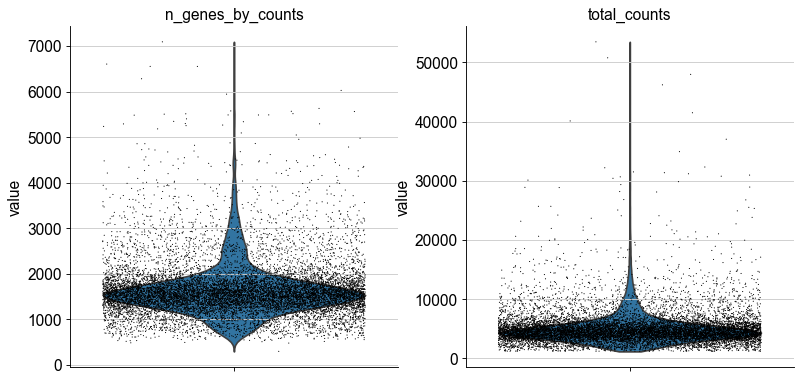

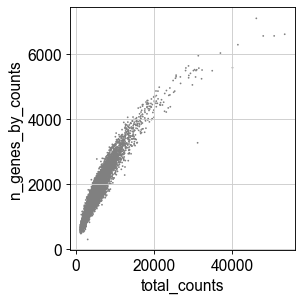

In [33]:
# Check data quality with violin and scatter plots
sc.pl.violin(integrated_adata, ['n_genes_by_counts', 'total_counts'], jitter=0.4, multi_panel=True)
sc.pl.scatter(integrated_adata, x='total_counts', y='n_genes_by_counts')

In [34]:
# Remove samples with too many gene counts
integrated_adata = integrated_adata[integrated_adata.obs.n_genes_by_counts < 5000, :]

c:\Users\spack\OneDrive - King's College London\Individual Project\scanpy_2\lib\site-packages\pandas\core\arrays\categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [35]:
# Normalise and logarithmise the matrix
sc.pp.normalize_total(integrated_adata, target_sum=1e4)
sc.pp.log1p(integrated_adata)

c:\Users\spack\OneDrive - King's College London\Individual Project\scanpy_2\lib\site-packages\scanpy\preprocessing\_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
normalizing counts per cell
    finished (0:00:00)


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


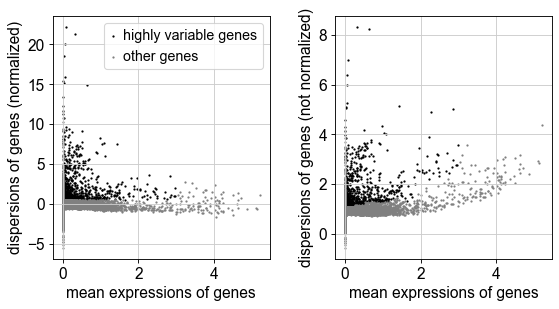

In [36]:
# Identify highly expressed genes
sc.pp.highly_variable_genes(integrated_adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(integrated_adata)

In [37]:
# Set raw attribute to be the processed data
integrated_adata.raw = integrated_adata

In [38]:
# Filter out non-highly expressed genes
integrated_adata = integrated_adata[:, integrated_adata.var.highly_variable]

# Scale the data
sc.pp.scale(integrated_adata, max_value=10)

c:\Users\spack\OneDrive - King's College London\Individual Project\scanpy_2\lib\site-packages\scanpy\preprocessing\_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


## PCA

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:03)


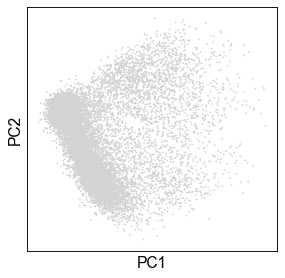

In [39]:
sc.tl.pca(integrated_adata, svd_solver='arpack')
sc.pl.pca(integrated_adata)

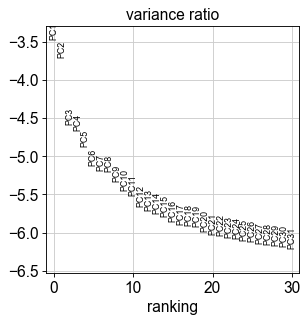

In [40]:
# Identify the PCs contributing to the total variance
sc.pl.pca_variance_ratio(integrated_adata, log=True)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:49)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:13)


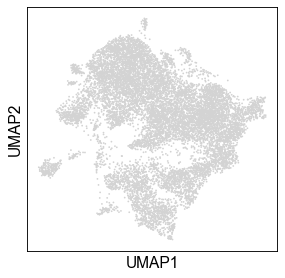

In [41]:
# Carry out UMAP
sc.pp.neighbors(integrated_adata, n_neighbors=10, n_pcs=40)

sc.tl.umap(integrated_adata)
sc.pl.umap(integrated_adata)

## Clustering

In [42]:
# Create clusters
sc.tl.leiden(integrated_adata)

running Leiden clustering
    finished: found 22 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:03)


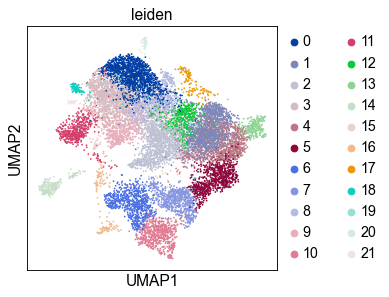

In [45]:
sc.pl.umap(integrated_adata, color='leiden')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:30)


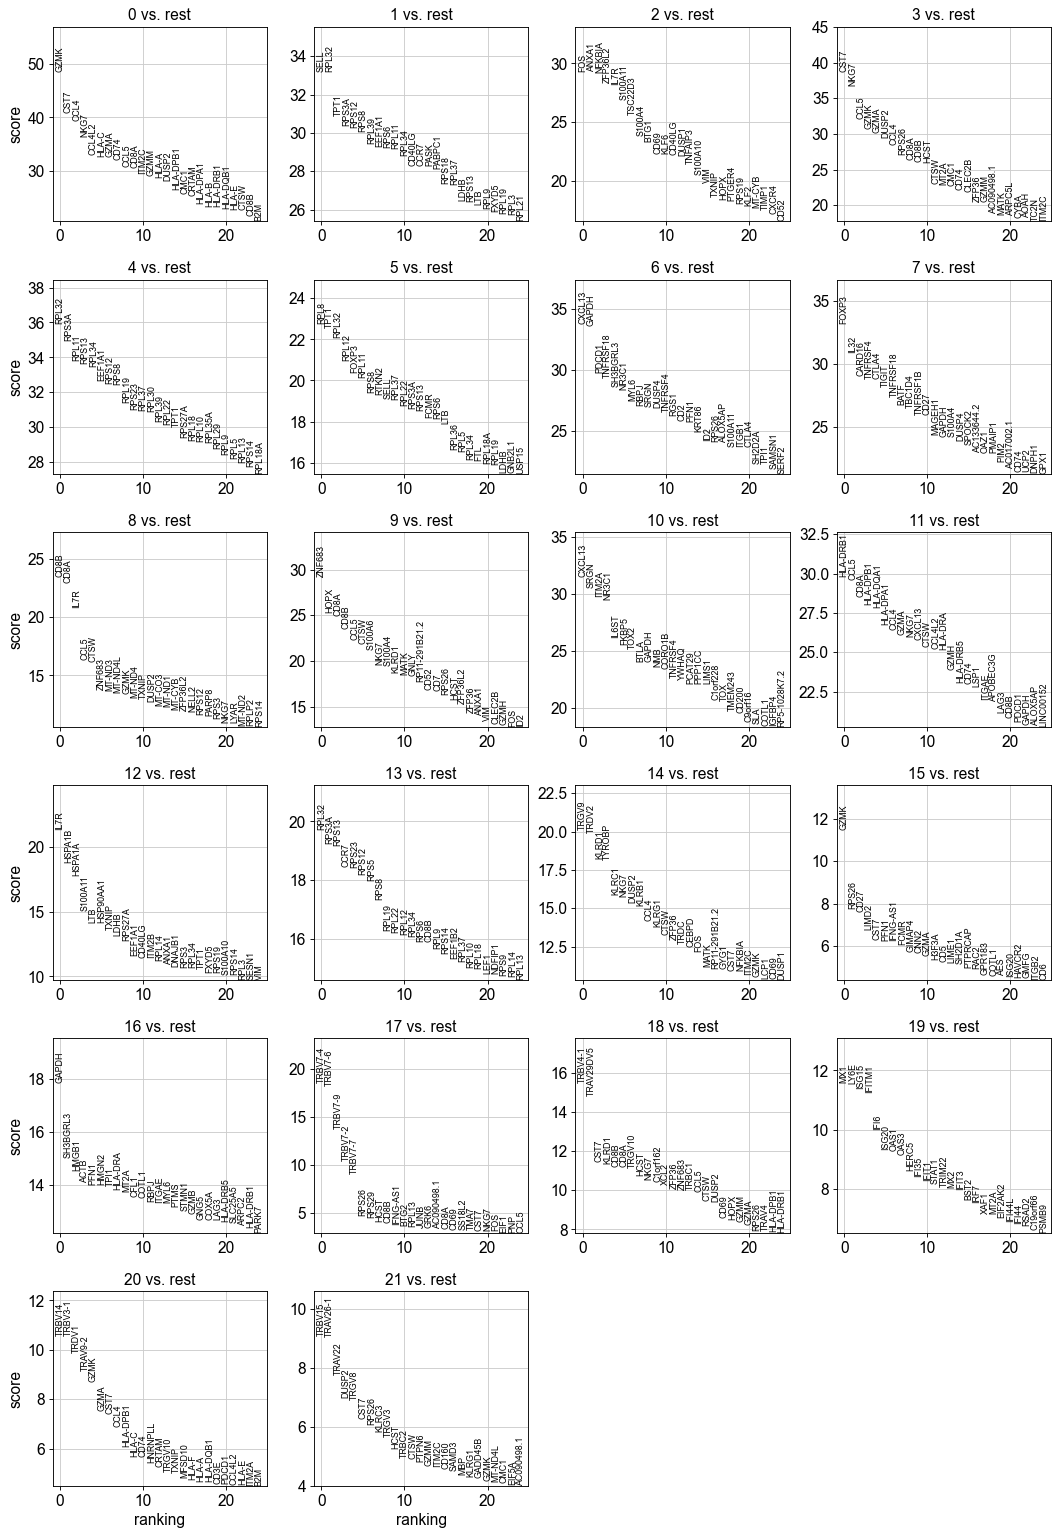

In [46]:
## Find marker genes
sc.tl.rank_genes_groups(integrated_adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(integrated_adata, n_genes=25, sharey=False)

In [47]:
# Get names of most likely marker genes for each cluster
cluster_names = list(integrated_adata.uns['rank_genes_groups']['names'][0])

In [94]:
cluster_names = ['GZMK',
    'IL7R',
    'NR3C1',
    'RPL32',
    'CD8A',
    'FOXP3',
    'NOPE',
    'CXCL13',
    'NOPE2',
    'TRBV4-1',
    'GZMB',
    'CTSW',
    'TRBV7-4',
    'STMN1',
    'TRBV15',
    'KLRB1']

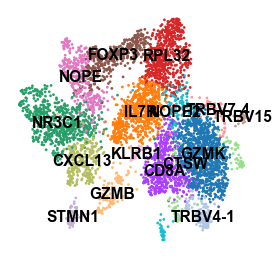

In [95]:
# Plot clusters
integrated_adata.rename_categories('leiden', cluster_names)
sc.pl.umap(integrated_adata, color='leiden', legend_loc='on data', title='', frameon=False)

In [69]:
export_data = pd.DataFrame(integrated_adata.X, index = integrated_adata.obs.index, columns = integrated_adata.var.index)
export_data

ISG15  TNFRSF18   TNFRSF4    PLCH2      PER3  \
AAACCTGAGCTGGAAC-1-10  1.339975 -0.378983 -0.453022 -0.13524 -0.122623   
AAACCTGCACCGCTAG-1-10 -0.588921 -0.378983 -0.453022 -0.13524 -0.122623   
AAACCTGCACGCCAGT-1-10  1.465288 -0.378983 -0.453022 -0.13524 -0.122623   
AAACCTGGTAGGGTAC-1-10  0.799260 -0.378983 -0.453022 -0.13524 -0.122623   
AAACCTGGTTAAGGGC-1-10 -0.588921 -0.378983 -0.453022 -0.13524 -0.122623   
...                         ...       ...       ...      ...       ...   
TTTGTCACAGATGGGT-1-09 -0.588921 -0.378983 -0.453022 -0.13524 -0.122623   
TTTGTCACAGGGATTG-1-09 -0.588921 -0.378983  1.111132 -0.13524 -0.122623   
TTTGTCAGTCCGACGT-1-09 -0.588921 -0.378983 -0.453022 -0.13524 -0.122623   
TTTGTCAGTCCTAGCG-1-09 -0.588921 -0.378983 -0.453022 -0.13524 -0.122623   
TTTGTCATCATCGATG-1-09  1.907336 -0.378983 -0.453022 -0.13524 -0.122623   

                        TNFRSF9     KIF1B   TNFRSF8  TNFRSF1B      SPEN  ...  \
AAACCTGAGCTGGAAC-1-10 -0.262443 -0.171054 -0.085286  0.913223 -0.349366  ...   
AAACCTGCACCGCTAG-1-10 -0.262443 -0.171054 -0.085286  1.078520 -0.349366  ...   
AAACCTGCACGCCAGT-1-10  3.180725 -0.171054 -0.085286 -0.752545 -0.349366  ...   
AAACCTGGTAGGGTAC-1-10 -0.262443 -0.171054 -0.085286  0.446270 -0.349366  ...   
AAACCTGGTTAAGGGC-1-10 -0.262443 -0.171054 -0.085286  0.737242 -0.349366  ...   
...                         ...       ...       ...       ...       ...  ...   
TTTGTCACAGATGGGT-1-09 -0.262443 -0.171054 -0.085286  0.631268 -0.349366  ...   
TTTGTCACAGGGATTG-1-09 -0.262443 -0.171054 -0.085286 -0.752545  2.488750  ...   
TTTGTCAGTCCGACGT-1-09 -0.262443 -0.171054 -0.085286 -0.752545 -0.349366  ...   
TTTGTCAGTCCTAGCG-1-09 -0.262443 -0.171054 -0.085286  0.552432 -0.349366  ...   
TTTGTCATCATCGATG-1-09 -0.262443 -0.171054 -0.085286 -0.752545 -0.349366  ...   

                         SAMSN1  LINC00158  MIR155HG       APP  AF131217.1  \
AAACCTGAGCTGGAAC-1-10 -0.687496  -0.108568 -0.366036 -0.280732   -0.252315   
AAACCTGCACCGCTAG-1-10  1.253341  -0.108568 -0.366036 -0.280732   -0.252315   
AAACCTGCACGCCAGT-1-10 -0.687496  -0.108568 -0.366036 -0.280732    4.062200   
AAACCTGGTAGGGTAC-1-10 -0.687496  -0.108568  1.339987 -0.280732   -0.252315   
AAACCTGGTTAAGGGC-1-10 -0.687496  -0.108568  3.392674 -0.280732   -0.252315   
...                         ...        ...       ...       ...         ...   
TTTGTCACAGATGGGT-1-09 -0.687496  -0.108568  3.196307  2.873549   -0.252315   
TTTGTCACAGGGATTG-1-09  0.914485  -0.108568  1.784788 -0.280732   -0.252315   
TTTGTCAGTCCGACGT-1-09  2.008530  -0.108568 -0.366036 -0.280732   -0.252315   
TTTGTCAGTCCTAGCG-1-09 -0.687496  -0.108568 -0.366036 -0.280732   -0.252315   
TTTGTCATCATCGATG-1-09 -0.687496  -0.108568 -0.366036 -0.280732   -0.252315   

                         TIAM1       MX1  ITGB2-AS1     S100B    MT-ND6  
AAACCTGAGCTGGAAC-1-10 -0.39163 -0.497181  -0.542304 -0.090045 -1.017512  
AAACCTGCACCGCTAG-1-10 -0.39163 -0.497181   1.843652 -0.090045 -1.017512  
AAACCTGCACGCCAGT-1-10 -0.39163 -0.497181   1.769277 -0.090045  0.504534  
AAACCTGGTAGGGTAC-1-10 -0.39163 -0.497181   1.019803 -0.090045 -1.017512  
AAACCTGGTTAAGGGC-1-10 -0.39163 -0.497181   1.398952 -0.090045  0.856177  
...                        ...       ...        ...       ...       ...  
TTTGTCACAGATGGGT-1-09 -0.39163 -0.497181   1.260864 -0.090045 -1.017512  
TTTGTCACAGGGATTG-1-09 -0.39163 -0.497181   1.427081 -0.090045  0.279218  
TTTGTCAGTCCGACGT-1-09 -0.39163  1.853872  -0.542304 -0.090045  0.523043  
TTTGTCAGTCCTAGCG-1-09 -0.39163 -0.497181   1.158137 -0.090045 -1.017512  
TTTGTCATCATCGATG-1-09 -0.39163 -0.497181  -0.542304 -0.090045 -1.017512  

[11992 rows x 979 columns]

In [71]:
# Save count matrix
export_data.to_csv("integrated.csv")

In [ ]:
# Write results
adata.write(results_file)